# DAN - Reuters

In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from custom_layers import AverageWords, WordDropout 
from preprocess import PreProcessor

In [70]:
# Model imports
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.layers import Embedding, Dense, Input, BatchNormalization, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adagrad, Adam
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Variables

In [2]:
num_classes = 8
SEED = 333
max_words = 10000

## Data loading

In [133]:
#TRAIN_PATH = "../../data/data_reuters/r8-train-all-terms.txt"
#TEST_PATH = "../../data/data_reuters/r8-test-all-terms.txt"

TRAIN_PATH = "../../data/data_reuters/r8-train-stemmed.txt"
TEST_PATH = "../../data/data_reuters/r8-test-stemmed.txt"

train = pd.read_csv(TRAIN_PATH, sep="\t", header=None)
test = pd.read_csv(TEST_PATH, sep="\t", header=None)

x_train_txt = train[1].values
y_train_txt = train[0].values
x_test_txt = test[1].values
y_test_txt = test[0].values

print(len(x_train_txt), 'train sequences')
print(len(x_test_txt), 'test sequences')

5485 train sequences
2189 test sequences


In [134]:
x_train_txt[0]

'champion product approv stock split champion product inc board director approv two for stock split common share for sharehold record april compani board vote recommend sharehold annual meet april increas author capit stock mln mln share reuter'

## Prep labels (y_test, y_train)

In [135]:
labels = sorted(set(test[0]))

y_test = [labels.index(l) for l in y_test_txt]
y_train = [labels.index(l) for l in y_train_txt]

In [136]:
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = keras.utils.to_categorical(y_train, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (5485, 8)
y_test shape: (2189, 8)


### Split data

In [137]:
x_train80_txt, x_val_txt, y_train80, y_val = train_test_split(x_train_txt, y_train, test_size=0.2, random_state=SEED, shuffle=True)

In [138]:
print('y_train80 shape:', y_train80.shape)
print('y_val shape:', y_val.shape)

y_train80 shape: (4388, 8)
y_val shape: (1097, 8)


## Tokenize the data

In [275]:
print('Vectorizing sequence data...')
tok = Tokenizer(num_words=7000)
tok.fit_on_texts(x_train80_txt)
# summarize what was learned
print(tok.document_count)

Vectorizing sequence data...
4388


In [276]:
len(tok.word_counts)

13075

In [277]:
x_train80 = tok.texts_to_sequences(x_train80_txt)
x_val = tok.texts_to_sequences(x_val_txt)
x_test = tok.texts_to_sequences(x_test_txt)

### Data padding

In [278]:
MAX_SEQUENCE_LENGTH = max([len(x_train80[i]) for i in range(len(x_train80))])
MAX_SEQUENCE_LENGTH = 200

x_train80 = pad_sequences(x_train80, maxlen=MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

In [279]:
MAX_SEQUENCE_LENGTH

200

## Model

Code base from https://github.com/aravindsiv/dan_qa (also AverageWords, WordDropout layers)

In [282]:
embedding_dim = 300
num_hidden_layers = 3
num_hidden_units = 300
num_epochs = 100
batch_size = 256
dropout_rate = 0.2
word_dropout_rate = 0.3
weight_decay = 1e-5
activation = 'relu'
num_classes = y_train80.shape[1]
print("Number of classes:", num_classes)

Number of classes: 8


In [283]:
model = Sequential()
model.add(Embedding(len(tok.word_index) + 1,embedding_dim,input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(WordDropout(word_dropout_rate))
model.add(AverageWords())

for i in range(num_hidden_layers):
    model.add(Dense(num_hidden_units, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    #model.add(Dropout(dropout_rate))

model.add(Dense(num_classes, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay)))
#model.add(BatchNormalization())  # Last batch norm needed?
#model.add(Dropout(dropout_rate))
model.add(Activation('softmax'))

adagrad = optimizers.Adagrad(lr=0.1)
model.compile(loss='categorical_crossentropy',optimizer=adagrad,metrics=['accuracy'])

#model.summary()

In [284]:
cbks = [EarlyStopping(patience=25), ReduceLROnPlateau(patience=10, verbose=1)]

In [285]:
hist = model.fit(x_train80, y_train80, batch_size=batch_size, epochs=num_epochs, validation_data=(x_val,y_val), callbacks=cbks)

Train on 4388 samples, validate on 1097 samples
Epoch 1/100
4388/4388 [==============================] - 13s - loss: 3.0865 - acc: 0.4733 - val_loss: 4.5527 - val_acc: 0.4959
Epoch 2/100
4388/4388 [==============================] - 9s - loss: 1.7716 - acc: 0.6165 - val_loss: 3.1274 - val_acc: 0.3245
Epoch 3/100
4388/4388 [==============================] - 8s - loss: 1.2697 - acc: 0.6784 - val_loss: 1.4979 - val_acc: 0.5251
Epoch 4/100
4388/4388 [==============================] - 9s - loss: 0.9801 - acc: 0.7199 - val_loss: 1.9651 - val_acc: 0.3200
Epoch 5/100
4388/4388 [==============================] - 9s - loss: 0.8505 - acc: 0.7564 - val_loss: 2.0394 - val_acc: 0.5397
Epoch 6/100
4388/4388 [==============================] - 7s - loss: 0.7518 - acc: 0.7817 - val_loss: 2.5904 - val_acc: 0.3072
Epoch 7/100
4388/4388 [==============================] - 7s - loss: 0.7092 - acc: 0.7917 - val_loss: 2.1166 - val_acc: 0.3291
Epoch 8/100
4388/4388 [==============================] - 8s - loss: 0

In [173]:
from matplotlib import pyplot as plt

def plot_hist(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

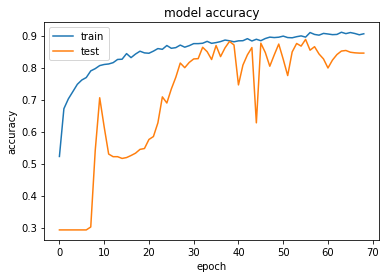

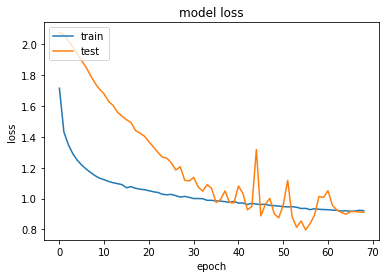

In [239]:
plot_hist(hist)

In [235]:
model.evaluate(x_test, y_test)

2080/2189 [===========================>..] - ETA: 0s

[0.46402216891601999, 0.92873458202814285]